# Data preparation for regression analysis

In [1]:
from toolbox import ToolBox
from tqdm import tqdm

from models import *

tqdm.pandas()

In [2]:
import pandas as pd
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta
from datetime import date
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
tb = ToolBox()

## Load user review data from database

In [8]:
df = tb.load_data_sql(table='user_reviews_clean', use_cache=True)
df = df[~df['review'].isnull()]
df.head()

Loaded from cache


,id,date,grade,game,review,sentiment
0,128002,2013-01-19,30,007-legends-pc,"Oh, my dear God! What is it with developers th...",-0.9191
1,128003,2014-06-23,30,007-legends-pc,Seriously if you want to have a HUGE laugh wit...,0.9424
2,128004,2014-12-11,0,007-legends-pc,godawful port of the xbox 360 version and ps3....,-0.3869
3,128005,2012-11-03,0,007-legends-pc,Agree. Worst game ever. Its a full copy of Cal...,0.5496
4,128006,2012-11-04,0,007-legends-pc,DO NOT BUY THIS GAME for the PC (or for any ot...,-0.9612


In [9]:
len(df)

211773

### User review df processing

In [10]:
# getting the minimum review data of a game as proxy for release date
min_dates = pd.DataFrame(df.groupby('game', as_index=False).agg({'date': 'min'}))
min_dates.rename(columns={'date':'release_date'}, inplace=True)

In [11]:
min_dates.head()

,game,release_date
0,007-legends-pc,2012-11-03
1,007-legends-playstation-3,2012-10-16
2,007-legends-wii-u,2013-01-04
3,007-legends-xbox-360,2012-10-16
4,007-quantum-of-solace-pc,2011-06-22


In [12]:
# merge release date with df
df = pd.merge(df, min_dates, on='game')

In [13]:
df.head()

,id,date,grade,game,review,sentiment,release_date
0,128002,2013-01-19,30,007-legends-pc,"Oh, my dear God! What is it with developers th...",-0.9191,2012-11-03
1,128003,2014-06-23,30,007-legends-pc,Seriously if you want to have a HUGE laugh wit...,0.9424,2012-11-03
2,128004,2014-12-11,0,007-legends-pc,godawful port of the xbox 360 version and ps3....,-0.3869,2012-11-03
3,128005,2012-11-03,0,007-legends-pc,Agree. Worst game ever. Its a full copy of Cal...,0.5496,2012-11-03
4,128006,2012-11-04,0,007-legends-pc,DO NOT BUY THIS GAME for the PC (or for any ot...,-0.9612,2012-11-03


In [14]:
# define a function to calculate difference in weeks between release date and review date
def difference_weeks(date, release_date):
    date_dif=date-release_date
    weeks = math.floor(date_dif/np.timedelta64(1,'W'))
    return weeks

In [15]:
# apply function on each row in df
df['week'] = df.apply(lambda row: difference_weeks(row['date'], row['release_date']), axis=1)

In [16]:
df.head()

,id,date,grade,game,review,sentiment,release_date,week
0,128002,2013-01-19,30,007-legends-pc,"Oh, my dear God! What is it with developers th...",-0.9191,2012-11-03,11
1,128003,2014-06-23,30,007-legends-pc,Seriously if you want to have a HUGE laugh wit...,0.9424,2012-11-03,85
2,128004,2014-12-11,0,007-legends-pc,godawful port of the xbox 360 version and ps3....,-0.3869,2012-11-03,109
3,128005,2012-11-03,0,007-legends-pc,Agree. Worst game ever. Its a full copy of Cal...,0.5496,2012-11-03,0
4,128006,2012-11-04,0,007-legends-pc,DO NOT BUY THIS GAME for the PC (or for any ot...,-0.9612,2012-11-03,0


#### Check how user reviews are distributed over the weeks after release

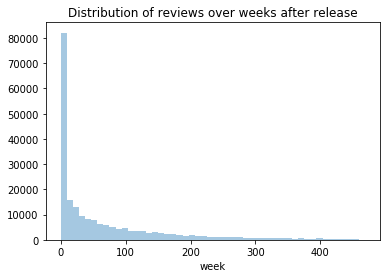

In [17]:
sns.distplot(df.week, kde=False);
plt.title('Distribution of reviews over weeks after release')
plt.show()

### Further preprocessing - defining timeframes

In [18]:
# Create timeframes of 3 weeks
df['timeframe'] = df['week'].apply(lambda week: week//3)

In [19]:
df.head()

,id,date,grade,game,review,sentiment,release_date,week,timeframe
0,128002,2013-01-19,30,007-legends-pc,"Oh, my dear God! What is it with developers th...",-0.9191,2012-11-03,11,5
1,128003,2014-06-23,30,007-legends-pc,Seriously if you want to have a HUGE laugh wit...,0.9424,2012-11-03,85,42
2,128004,2014-12-11,0,007-legends-pc,godawful port of the xbox 360 version and ps3....,-0.3869,2012-11-03,109,54
3,128005,2012-11-03,0,007-legends-pc,Agree. Worst game ever. Its a full copy of Cal...,0.5496,2012-11-03,0,0
4,128006,2012-11-04,0,007-legends-pc,DO NOT BUY THIS GAME for the PC (or for any ot...,-0.9612,2012-11-03,0,0


#### Calculate nr of reviews per timeframe

In [41]:
# empty matrix to define nr of reviews per timeframe  
reviews_per_timeframe = pd.DataFrame(np.zeros((len(df.groupby('game')), 2), dtype=np.int8), index=df.game.unique())

# enter reviews
for index, row in df[df['timeframe']<=1].iterrows():
    reviews_per_timeframe.loc[row['game'], row['timeframe']] += 1

reviews_per_timeframe.reset_index(inplace=True)
reviews_per_timeframe.rename(columns={'index': 'game'}, inplace=True)
    
# create cross-sectional dataset from matrix
#reviews_per_timeframe = reviews_per_timeframe.melt(id_vars=['game'], var_name='timeframe', value_name='nr_reviews')
#reviews_per_timeframe.sort_values(['game', 'timeframe'], inplace=True)

In [42]:
reviews_per_timeframe.head()

,game,0,1
0,007-legends-pc,7,1
1,007-legends-playstation-3,2,3
2,007-legends-wii-u,1,0
3,007-legends-xbox-360,8,1
4,007-quantum-of-solace-pc,2,0


In [43]:
reviews_per_timeframe.corr()

,0,1
0,1.000000,0.654468
1,0.654468,1.000000


In [22]:
# calculate variables average grade and sentiment per timeframe
reviews_grouped = df.groupby(['game', 'timeframe'], as_index=False).agg({'grade': 'mean', 'sentiment': 'std'})
reviews_grouped.rename(columns={'grade': 'user_avg_grade', 'sentiment': 'user_sentiment_var'}, inplace=True)

In [23]:
reviews_grouped.head()

,game,timeframe,user_avg_grade,user_sentiment_var
0,007-legends-pc,0,1.428571,0.549131
1,007-legends-pc,1,100.000000,NaN
2,007-legends-pc,3,70.000000,NaN
3,007-legends-pc,5,30.000000,NaN
4,007-legends-pc,7,60.000000,NaN


In [24]:
# create cross-sectional dataset including average grade and sentiment per timeframe
user_reviews = pd.merge(reviews_per_timeframe, reviews_grouped, how='left', on=['game', 'timeframe'])

In [25]:
user_reviews.head()

,game,timeframe,nr_reviews,user_avg_grade,user_sentiment_var
0,007-legends-pc,0,7,1.428571,0.549131
1,007-legends-pc,1,1,100.000000,NaN
2,007-legends-playstation-3,0,2,25.000000,0.177060
3,007-legends-playstation-3,1,3,33.333333,0.820714
4,007-legends-wii-u,0,1,40.000000,NaN


In [36]:
test = user_reviews[user_reviews['timeframe']==0]
test = test[test['nr_reviews']>1]

In [40]:
test.median()

nr_reviews             5.000000
user_avg_grade        76.666667
user_sentiment_var     0.550783
dtype: float64

In [22]:
# create a lag of time variant independent variables
user_reviews_lagged = user_reviews
user_reviews_lagged[['user_avg_grade', 'user_sentiment_var']] = user_reviews.groupby(['game'])['user_avg_grade', 'user_sentiment_var'].shift(1)

In [23]:
user_reviews_lagged.head()

,game,timeframe,nr_reviews,user_avg_grade,user_sentiment_var
0,007-legends-pc,0,7,NaN,NaN
1,007-legends-pc,1,1,1.428571,0.549131
2,007-legends-playstation-3,0,2,NaN,NaN
3,007-legends-playstation-3,1,3,25.000000,0.177060
4,007-legends-wii-u,0,1,NaN,NaN


## Critic review df preprocessing

In [24]:
critics = pd.read_pickle('../../datasets/critic_review_clean.pkl')

In [25]:
critics.head()

,game,date,grade,review,sentiment
0,007-legends-pc,2012-12-03,35.0,"Unfortunately the game proves the fact, that d...",-0.3400
1,007-legends-pc,2012-12-21,30.0,The worst gift agent 007 could possibly get to...,-0.6399
2,007-legends-pc,2013-01-05,16.0,"Legends, you're the worst. [Feb 2013, p.79]",-0.6249
3,007-legends-pc,2013-02-06,28.0,"Why put yourself through this ordeal, when the...",0.0972
4,007-legends-pc,2013-01-29,25.0,007 Legends greets you with a warning that Act...,-0.7916


In [26]:
def critic_preprocessing(df):
    # create aggregated variables for each game
    reviews_grouped = df.groupby(['game'], as_index=False).agg({'grade': 'mean', 
                                                                'sentiment': 'std', 
                                                                'review': 'count'
                                                               })
    
    reviews_grouped.rename({'grade': 'critic_avg_grade', 
                            'sentiment': 'critic_sentiment_var',
                            'review': 'critic_volume'
                           }, inplace=True, axis=1)
    
    return reviews_grouped

In [27]:
critic_reviews = critic_preprocessing(critics)

In [28]:
critic_reviews.head()

,game,critic_avg_grade,critic_sentiment_var,critic_volume
0,007-legends-pc,26.800000,0.351563,5
1,007-legends-playstation-3,42.318182,0.619410,22
2,007-legends-wii-u,40.666667,0.080168,3
3,007-legends-xbox-360,46.448980,0.669014,49
4,007-quantum-of-solace-ds,64.300000,0.411520,10


In [29]:
len(critic_reviews)

16865

## Control variables: genre and console

In [30]:
fields = ['game', 'genre', 'console']
genre_console = pd.read_csv('../../datasets/cross-sectional-data-with-control-variables.csv', usecols=fields)

In [31]:
genre_console.head()

,game,genre,console
0,007-legends-pc,Action,pc
1,007-legends-playstation-3,Action,playstation-3
2,007-legends-wii-u,Action,wii-u
3,007-legends-xbox-360,Action,xbox-360
4,007-quantum-of-solace-pc,Action,pc


## Create final cross sectional dataframe - Count Models

In [32]:
# merge user and critic review dataframe
user_critics_cs = pd.merge(user_reviews_lagged, critic_reviews, how='left', on='game')

In [33]:
len(user_critics_cs)

26136

In [34]:
user_critics_cs.describe()

,nr_reviews,user_avg_grade,user_sentiment_var,critic_avg_grade,critic_sentiment_var,critic_volume
count,26136.000000,13068.000000,4637.000000,23710.000000,22706.000000,23720.000000
mean,2.436180,71.083674,0.501503,70.004170,0.477669,22.776644
std,6.369977,26.111579,0.349388,14.067486,0.138779,19.947884
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,60.000000,0.140447,62.422932,0.404505,7.000000
50%,1.000000,80.000000,0.550783,72.354167,0.489651,17.000000
75%,2.000000,90.000000,0.760859,80.000000,0.562654,32.000000
max,191.000000,100.000000,1.409759,100.000000,1.310481,129.000000


In [35]:
# merge review dataframe with control variables genre and console
df_cs = pd.merge(user_critics_cs, genre_console, how='left', on='game')

In [36]:
df_cs.head()

,game,timeframe,nr_reviews,user_avg_grade,user_sentiment_var,critic_avg_grade,critic_sentiment_var,critic_volume,genre,console
0,007-legends-pc,0,8,NaN,NaN,26.800000,0.351563,5.0,Action,pc
1,007-legends-pc,1,0,13.75,0.744573,26.800000,0.351563,5.0,Action,pc
2,007-legends-playstation-3,0,3,NaN,NaN,42.318182,0.619410,22.0,Action,playstation-3
3,007-legends-playstation-3,1,2,40.00,0.950803,42.318182,0.619410,22.0,Action,playstation-3
4,007-legends-wii-u,0,1,NaN,NaN,40.666667,0.080168,3.0,Action,wii-u


In [37]:
df_cs_count_models = df_cs[df_cs['timeframe']==1].drop(columns='timeframe')

In [38]:
df_cs_count_models.head()

,game,nr_reviews,user_avg_grade,user_sentiment_var,critic_avg_grade,critic_sentiment_var,critic_volume,genre,console
1,007-legends-pc,0,13.750000,0.744573,26.800000,0.351563,5.0,Action,pc
3,007-legends-playstation-3,2,40.000000,0.950803,42.318182,0.619410,22.0,Action,playstation-3
5,007-legends-wii-u,0,40.000000,NaN,40.666667,0.080168,3.0,Action,wii-u
7,007-legends-xbox-360,2,37.777778,0.707120,46.448980,0.669014,49.0,Action,xbox-360
9,007-quantum-of-solace-pc,1,30.000000,0.933805,70.833333,0.542889,18.0,Action,pc


In [39]:
df_cs_count_models.dropna(how='any', inplace=True)

In [40]:
len(df_cs_count_models)

4610

In [54]:
df_cs_count_models.to_csv('../../datasets/final-df-count-models.csv', index=False)

## Dataframe for cross-sectional approach with minimum of 10 reviews per timeframe

In [43]:
# check minimum number of reviews over all periods for each game
games_min_reviews = df_cs.groupby(['game'], as_index=False).agg({'nr_reviews': 'min'})
games_min_reviews.rename(columns={'nr_reviews': 'min_reviews'}, inplace=True)
games_min_reviews.head()

,game,min_reviews
0,007-legends-pc,0
1,007-legends-playstation-3,2
2,007-legends-wii-u,0
3,007-legends-xbox-360,2
4,007-quantum-of-solace-pc,1


In [46]:
games_10_reviews = list(games_min_reviews[games_min_reviews['min_reviews']>=10]['game'])
len(games_10_reviews)

208

In [47]:
# filter all games with more than 10 reviews in each timeframe
df_cs_10_reviews = df_cs[df_cs['game'].isin(games_10_reviews)]

In [50]:
df_cs_10_reviews = df_cs_10_reviews[df_cs_10_reviews['timeframe']==1].drop(columns='timeframe')

In [51]:
df_cs_10_reviews.head()

,game,nr_reviews,user_avg_grade,user_sentiment_var,critic_avg_grade,critic_sentiment_var,critic_volume,genre,console
199,a-hat-in-time-pc,11,90.416667,0.567230,79.282051,0.466825,41.0,Action,pc
217,a-plague-tale-innocence-pc,14,89.056604,0.459017,80.843750,0.552898,33.0,General,pc
219,a-plague-tale-innocence-playstation-4,12,86.610169,0.531837,82.491525,0.472003,63.0,General,playstation-4
695,aliens-colonial-marines-xbox-360,13,42.250000,0.811619,48.234043,0.639638,47.0,Action,xbox-360
813,amnesia-a-machine-for-pigs-pc,14,55.000000,0.793005,71.593220,0.607532,59.0,Action Adventure,pc


In [56]:
df_cs_10_reviews.to_csv('../../datasets/final-df-cs-10-reviews.csv', index=False)